In [21]:
import matplotlib.pyplot as plt
from BLEanalysis.synthetic import SignalDemo
from BLEanalysis.pathinference import Path_ProbabilityDensitiesToBee, Path_VectorsToBee
from BLEanalysis.kernels import ExponentiatedQuadraticKernel

demo = SignalDemo(sample_interval=300)
k = ExponentiatedQuadraticKernel(7.0,50.0)
path = Path_ProbabilityDensitiesToBee(demo.obstimes,demo.burst_observations,k,3.0,6)
path.run(200,learning_rate=2.0)#,just_optimise_means=True)

Standardising angles and times (shifting by 38.00 degrees)
Standardising angles and times (shifting by 38.00 degrees)
Optimising mean...
iteration    0:   22352.0
iteration   50:   20002.4
iteration  100:   19996.8
iteration  150:   19996.7
Optimising mean and covariance...
iteration    0:    7045.0
iteration   50:    4410.5
iteration  100:    3451.5
iteration  150:    2924.2


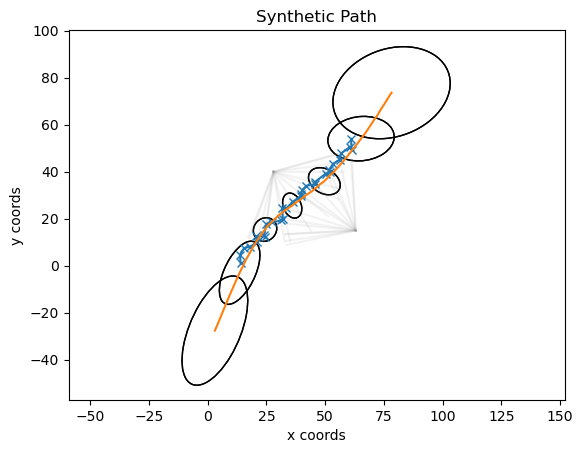

In [22]:
demo.plot()
path.plot(n_std=1)

## Comparison

As a quick comparison, here we find the mode of the angle distribution, and use that as a vector guess for inference, with the Path_VectorsToBee class: 

In [23]:
from BLEanalysis.angleinference import AnglesUsePatternMeans
angles = AnglesUsePatternMeans(noisevar=3**2)
import numpy as np
observations = []
for b in demo.burst_observations:
    logps,_,_,_ = angles.infer(b['rssis'],b['angles'])
    angle = np.linspace(0,np.pi*2,360)[np.argmax(logps)]
    obs = np.array([b['transmitter_position'][0],b['transmitter_position'][1],np.cos(angle),np.sin(angle)])
    observations.append(obs)
observations = np.array(observations)

Standardising angles and times (shifting by 38.00 degrees)


In [24]:
from BLEanalysis.pathinference import Path_VectorsToBee
path = Path_VectorsToBee(demo.obstimes,observations,k,6,0.1)
path.run(200,learning_rate=2.0)

Optimising mean...
iteration    0: 2463548.0
iteration   50:   40558.8
iteration  100:   32545.4
iteration  150:   31185.3
Optimising mean and covariance...
iteration    0:   71400.6
iteration   50:   14148.8
iteration  100:   13358.3
iteration  150:   13366.1


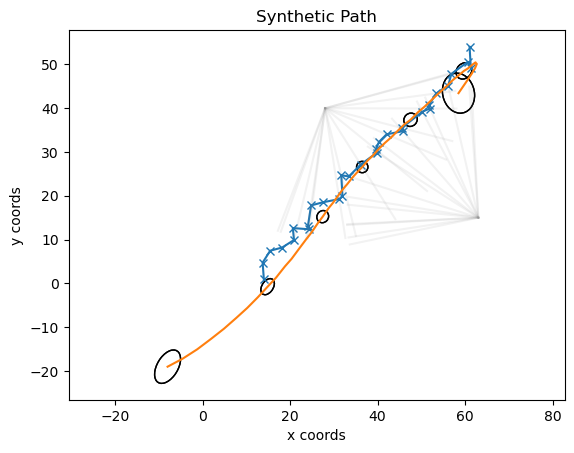

In [25]:
demo.plot()
path.plot(n_std=1)

# Note on the synthetic dataset

The observations consist of a list of dictionaries, each item contains:
 - the location of the transmitter
 - a list of RSSIs
 - a list of angles
TODO: A method in Signals should potentially generate this list from the data it has

In [26]:
demo.burst_observations[0]

{'transmitter_position': array([28., 40.]),
 'rssis': array([-68.,  nan, -81., -82., -80., -88., -75., -65.]),
 'angles': array([2.15978974,        nan, 3.99238545, 4.93486325, 5.77262129,
        6.71509909, 7.58776371, 2.2470562 ])}

To give an idea of the angle inference part of this, we will use the above data to infer the angle:

Standardising angles and times (shifting by 38.00 degrees)


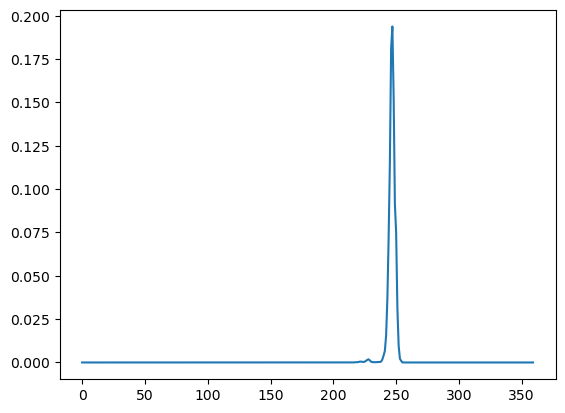

In [27]:
from BLEanalysis.angleinference import AnglesUsePatternMeans, normalise_logs_to_ps
angles = AnglesUsePatternMeans(noisevar=3**2)
import numpy as np
logps,_,_,_ = angles.infer(demo.burst_observations[0]['rssis'],demo.burst_observations[0]['angles'])
plt.plot(np.linspace(0,359,360),normalise_logs_to_ps(logps))